In [47]:
suppressMessages(library(dplyr))
library(ggplot2)
library(ggrepel) 
library(scales)
library(readxl)
library(stringr)
suppressMessages(library(purrr))
suppressMessages(library(magrittr))
suppressMessages(library(tidyr))
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
suppressMessages(library(ggmap))
suppressMessages(library(maps))
library(mapdata)

In [48]:
#Data import
# Goergia secretary of state- official results url - https://results.enr.clarityelections.com//GA//105369/271927/reports/detailxls.zip

rawdata2020 = data.frame(read_excel('detail 2020.xls', sheet = '1', skip = 1, col_names = TRUE)) 
names(rawdata2020) = NULL #remove the header due to gaps
colnames(rawdata2020) = rawdata2020[1,] #set 1st row as header
rawdata2020 = rawdata2020[-1,] #delete first row
rawdata2020[,c(2:ncol(rawdata2020))]=sapply(rawdata2020[,(2:ncol(rawdata2020))],as.numeric) # convert all columns with numbers to numeric
rawdata2020[,c(1)]=sapply(rawdata2020[,c(1)],tolower) # convert County column to lower case
names(rawdata2020) = gsub(" ", ".", names(rawdata2020)) #remove spaces in the column names
names(rawdata2020) = sapply(names(rawdata2020),tolower) #convert column headers to lower case
rawdata2020$county[rawdata2020$county =='dekalb'] = 'de kalb' # correct County dekalb in rawdata2020 to match county data
rawdata2020 = rawdata2020[-nrow(rawdata2020),] # remove last row containing total
rawdata2020$party = 'republican' # introduce party column
rawdata2020=rawdata2020[,c(1,18,2:17)] # reorder column names
rawdata2020 = rawdata2020 %>% mutate(winner = ifelse(total.votes>total.votes.1,'republican','democrat'))
rawdata2020=rawdata2020[,c(1,2,19,3:18)] # reorder column names
head(rawdata2020,n=5)


New names:
* `` -> ...1
* `` -> ...3
* `` -> ...4
* `` -> ...5
* `` -> ...6
* … and 9 more problems


county,party,winner,election.day.votes,absentee.by.mail.votes,advanced.voting.votes,provisional.votes,total.votes,election.day.votes.1,absentee.by.mail.votes.1,advanced.voting.votes.1,provisional.votes.1,total.votes.1,election.day.votes.2,absentee.by.mail.votes.2,advanced.voting.votes.2,provisional.votes.2,total.votes.2,total
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
appling,republican,republican,1753,890,3874,9,6526,334,587,855,3,1779,5,5,26,0,36,8341
atkinson,republican,republican,716,164,1419,1,2300,250,130,445,0,825,14,3,13,0,30,3155
bacon,republican,republican,431,487,3099,1,4018,140,196,288,1,625,8,4,13,0,25,4668
baker,republican,republican,291,138,466,2,897,149,234,269,0,652,2,2,2,0,6,1555
baldwin,republican,democrat,1873,1290,5736,4,8903,1527,3000,4612,1,9140,63,38,107,0,208,18251


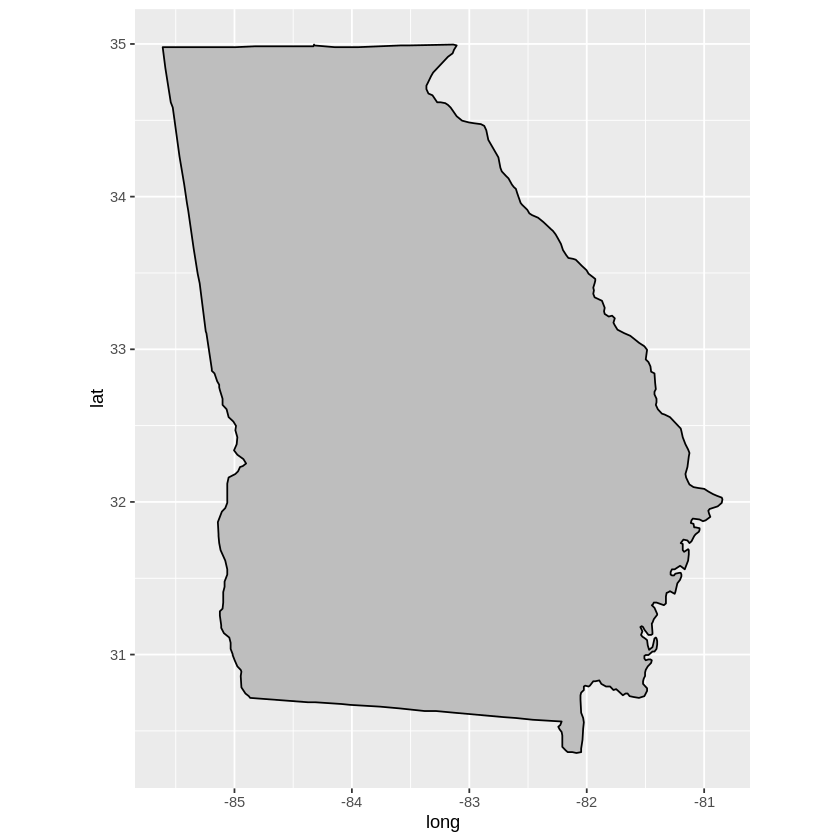

In [49]:
#georgia map construction
states = map_data("state")
ga_state = subset(states, region == "georgia")
counties = map_data("county")
ga_county = subset(counties, region == "georgia")
ga_base = ggplot(data = ga_state, mapping = aes(x = long, y = lat, group = group)) +
  coord_fixed(1.3) + geom_polygon(color = "black", fill = "gray")
ga_base

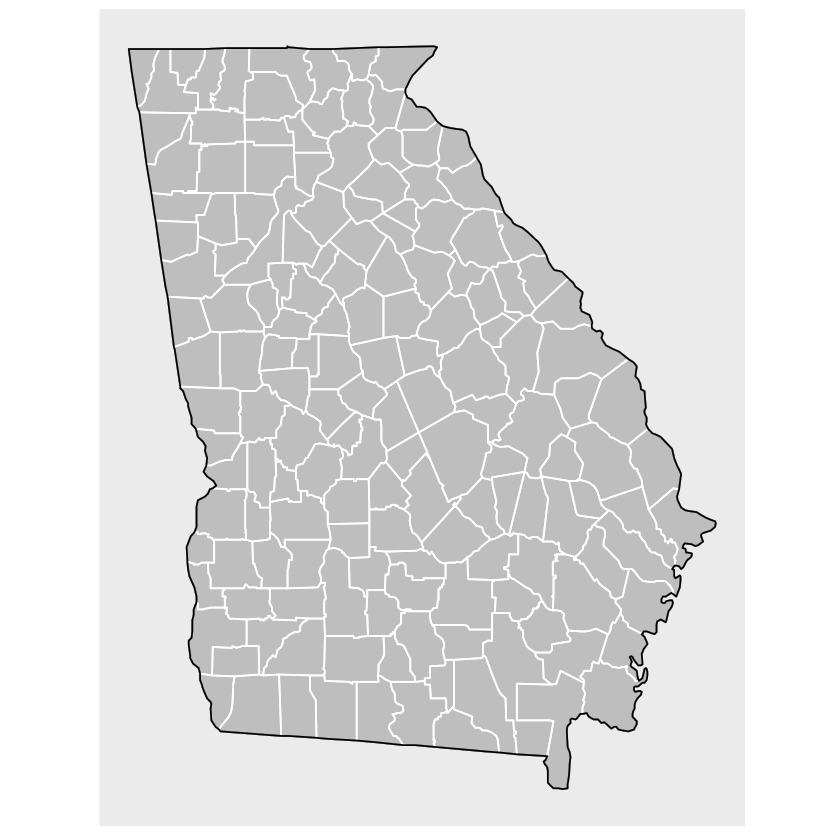

In [50]:
#we will use this to remove all of the axes and borders on our graph
remove_the_axis = theme(
  axis.text = element_blank(),
  axis.line = element_blank(),
  axis.ticks = element_blank(),
  panel.border = element_blank(),
  panel.grid = element_blank(),
  axis.title = element_blank()
)

#add outlines of the counties on which to our stage map
ga_base = ga_base + remove_the_axis +
  geom_polygon(data = ga_county, fill = NA, color = "white") +
  geom_polygon(color = "black", fill = NA)

ga_base

In [51]:
ga_county_list = ga_county %>% group_by(subregion) %>% summarize(count=n())
rawdata2020_county_count = left_join(rawdata2020,ga_county_list,by= c('county'="subregion"))
rawdata2020 = left_join(rawdata2020,ga_county_list,by= c('county'="subregion"))
rawdata2020= rawdata2020[,c(1:3,20,4:19)]
head(rawdata2020)
rawdata2020[-(1:4)]= rawdata2020[-(1:4)]/rawdata2020[,4][row(rawdata2020[-(1:4)])]
head(rawdata2020)

county,party,winner,count,election.day.votes,absentee.by.mail.votes,advanced.voting.votes,provisional.votes,total.votes,election.day.votes.1,absentee.by.mail.votes.1,advanced.voting.votes.1,provisional.votes.1,total.votes.1,election.day.votes.2,absentee.by.mail.votes.2,advanced.voting.votes.2,provisional.votes.2,total.votes.2,total
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
appling,republican,republican,55,1753,890,3874,9,6526,334,587,855,3,1779,5,5,26,0,36,8341
atkinson,republican,republican,24,716,164,1419,1,2300,250,130,445,0,825,14,3,13,0,30,3155
bacon,republican,republican,38,431,487,3099,1,4018,140,196,288,1,625,8,4,13,0,25,4668
baker,republican,republican,45,291,138,466,2,897,149,234,269,0,652,2,2,2,0,6,1555
baldwin,republican,democrat,39,1873,1290,5736,4,8903,1527,3000,4612,1,9140,63,38,107,0,208,18251
banks,republican,republican,22,1644,1025,5116,10,7795,150,344,435,3,932,20,9,45,0,74,8801


county,party,winner,count,election.day.votes,absentee.by.mail.votes,advanced.voting.votes,provisional.votes,total.votes,election.day.votes.1,absentee.by.mail.votes.1,advanced.voting.votes.1,provisional.votes.1,total.votes.1,election.day.votes.2,absentee.by.mail.votes.2,advanced.voting.votes.2,provisional.votes.2,total.votes.2,total
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
appling,republican,republican,55,31.872727,16.181818,70.43636,0.16363636,118.65455,6.072727,10.672727,15.545455,0.05454545,32.34545,0.09090909,0.09090909,0.47272727,0,0.6545455,151.65455
atkinson,republican,republican,24,29.833333,6.833333,59.12500,0.04166667,95.83333,10.416667,5.416667,18.541667,0.00000000,34.37500,0.58333333,0.12500000,0.54166667,0,1.2500000,131.45833
bacon,republican,republican,38,11.342105,12.815789,81.55263,0.02631579,105.73684,3.684211,5.157895,7.578947,0.02631579,16.44737,0.21052632,0.10526316,0.34210526,0,0.6578947,122.84211
baker,republican,republican,45,6.466667,3.066667,10.35556,0.04444444,19.93333,3.311111,5.200000,5.977778,0.00000000,14.48889,0.04444444,0.04444444,0.04444444,0,0.1333333,34.55556
baldwin,republican,democrat,39,48.025641,33.076923,147.07692,0.10256410,228.28205,39.153846,76.923077,118.256410,0.02564103,234.35897,1.61538462,0.97435897,2.74358974,0,5.3333333,467.97436
banks,republican,republican,22,74.727273,46.590909,232.54545,0.45454545,354.31818,6.818182,15.636364,19.772727,0.13636364,42.36364,0.90909091,0.40909091,2.04545455,0,3.3636364,400.04545


In [52]:
rawdata2020 = left_join(rawdata2020, ga_county, by = c('county'="subregion"))
rawdata2020 %>% group_by(county) %>% summarize(advanced.voting.votes=sum(advanced.voting.votes))

county,advanced.voting.votes
<chr>,<dbl>
appling,3874
atkinson,1419
bacon,3099
baker,466
baldwin,5736
banks,5116
barrow,16782
bartow,21499
ben hill,3140


In [53]:
ga_county_type = data.frame(read_excel('ga_urban_rural.xlsx', sheet = 'Sheet1', col_names = TRUE))
rawdata2020 = left_join(rawdata2020,ga_county_type,'county')

In [54]:
rawdata2020$county.type[is.na(rawdata2020$county.type)] = 'urban' #manual override - left join issue for DeKalb county

png 
  2

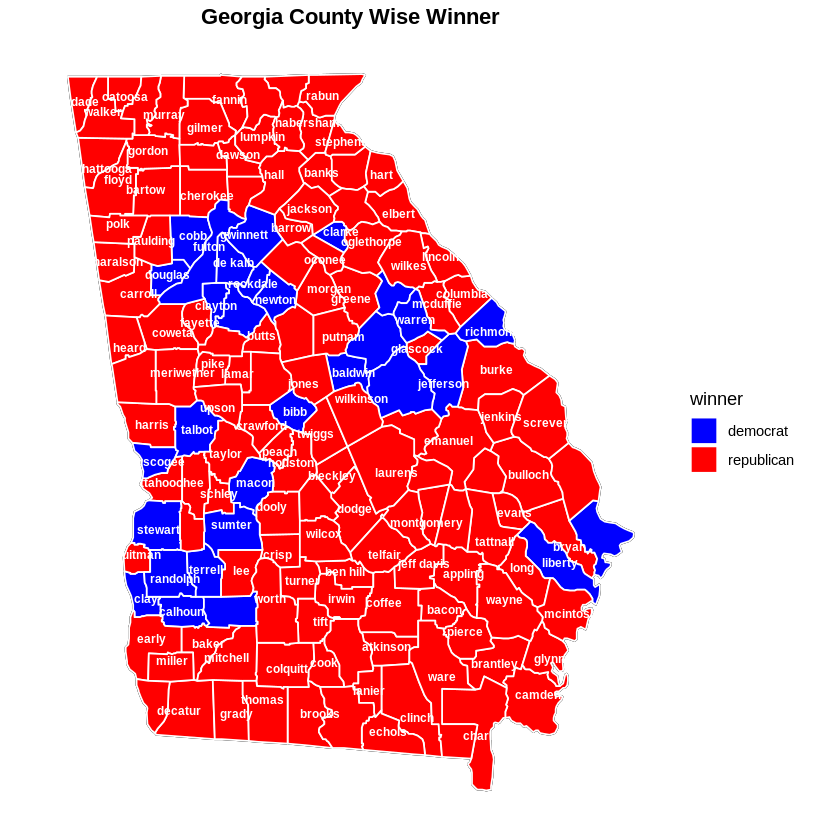

In [55]:
county_wise_winner <- ga_base +
  geom_polygon(data = rawdata2020, aes(fill = winner), color = "white") +
  theme_bw() +
  remove_the_axis +
  ggtitle("Georgia County Wise Winner") +
  scale_fill_manual(values= c('blue','red')) +
  geom_text(data= ga_county %>% group_by(subregion) %>% summarize(long=mean(long),lat=mean(lat)), 
                              aes(long,lat,label=subregion), fontface="bold",check_overlap = TRUE,inherit.aes = FALSE,size=2.5,color='white') +
theme(plot.title = element_text(face = "bold")) + theme(plot.title = element_text(hjust = 0.5))
county_wise_winner

png("county_wise_winner.png")
print(county_wise_winner)
dev.off()

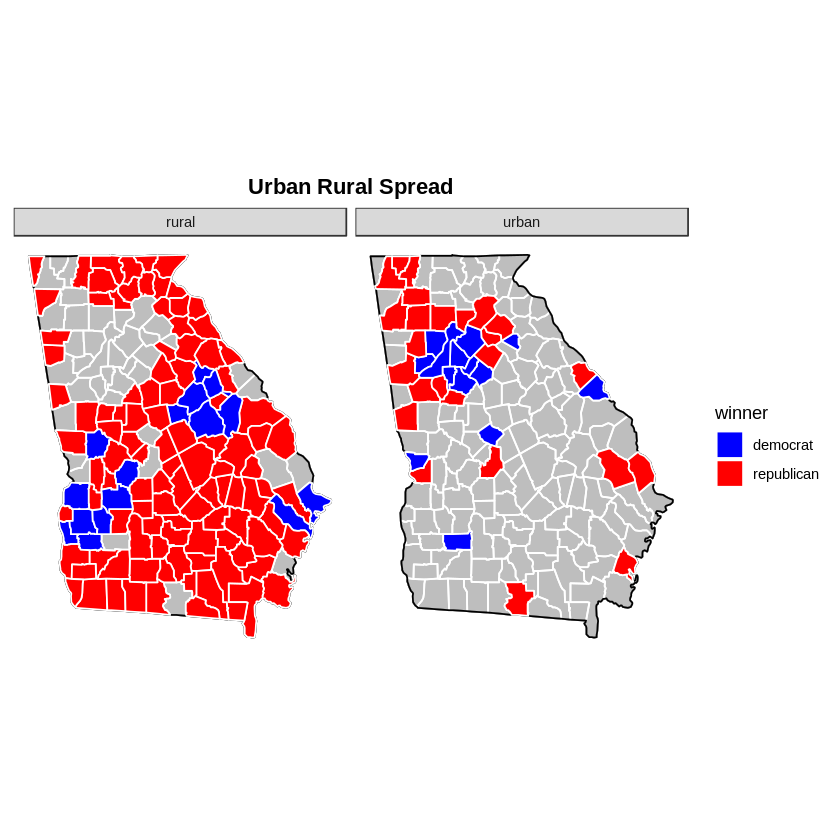

In [56]:
  county_type_spread = ga_base +
  geom_polygon(data = rawdata2020, aes(fill = winner), color = "white") +
  theme_bw() +
  remove_the_axis +
  ggtitle("Urban Rural Spread") + theme(plot.title = element_text(face = "bold")) + theme(plot.title = element_text(hjust = 0.5)) +
  scale_fill_manual(values= c('blue','red')) +facet_wrap(~county.type)
  county_type_spread





In [57]:
head(rawdata2020)
rawdata2020 = rawdata2020[,c(1:4,21:26,5:20)]
head(rawdata2020)

county,party,winner,count,election.day.votes,absentee.by.mail.votes,advanced.voting.votes,provisional.votes,total.votes,election.day.votes.1,⋯,advanced.voting.votes.2,provisional.votes.2,total.votes.2,total,long,lat,group,order,region,county.type
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
appling,republican,republican,55,31.87273,16.18182,70.43636,0.1636364,118.6545,6.072727,⋯,0.4727273,0,0.6545455,151.6545,-82.44862,31.94813,358,14727,georgia,rural
appling,republican,republican,55,31.87273,16.18182,70.43636,0.1636364,118.6545,6.072727,⋯,0.4727273,0,0.6545455,151.6545,-82.42570,31.94813,358,14728,georgia,rural
appling,republican,republican,55,31.87273,16.18182,70.43636,0.1636364,118.6545,6.072727,⋯,0.4727273,0,0.6545455,151.6545,-82.40852,31.94240,358,14729,georgia,rural
appling,republican,republican,55,31.87273,16.18182,70.43636,0.1636364,118.6545,6.072727,⋯,0.4727273,0,0.6545455,151.6545,-82.39706,31.94240,358,14730,georgia,rural
appling,republican,republican,55,31.87273,16.18182,70.43636,0.1636364,118.6545,6.072727,⋯,0.4727273,0,0.6545455,151.6545,-82.38560,31.93094,358,14731,georgia,rural
appling,republican,republican,55,31.87273,16.18182,70.43636,0.1636364,118.6545,6.072727,⋯,0.4727273,0,0.6545455,151.6545,-82.35122,31.91948,358,14732,georgia,rural


county,party,winner,count,long,lat,group,order,region,county.type,⋯,absentee.by.mail.votes.1,advanced.voting.votes.1,provisional.votes.1,total.votes.1,election.day.votes.2,absentee.by.mail.votes.2,advanced.voting.votes.2,provisional.votes.2,total.votes.2,total
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
appling,republican,republican,55,-82.44862,31.94813,358,14727,georgia,rural,⋯,10.67273,15.54545,0.05454545,32.34545,0.09090909,0.09090909,0.4727273,0,0.6545455,151.6545
appling,republican,republican,55,-82.42570,31.94813,358,14728,georgia,rural,⋯,10.67273,15.54545,0.05454545,32.34545,0.09090909,0.09090909,0.4727273,0,0.6545455,151.6545
appling,republican,republican,55,-82.40852,31.94240,358,14729,georgia,rural,⋯,10.67273,15.54545,0.05454545,32.34545,0.09090909,0.09090909,0.4727273,0,0.6545455,151.6545
appling,republican,republican,55,-82.39706,31.94240,358,14730,georgia,rural,⋯,10.67273,15.54545,0.05454545,32.34545,0.09090909,0.09090909,0.4727273,0,0.6545455,151.6545
appling,republican,republican,55,-82.38560,31.93094,358,14731,georgia,rural,⋯,10.67273,15.54545,0.05454545,32.34545,0.09090909,0.09090909,0.4727273,0,0.6545455,151.6545
appling,republican,republican,55,-82.35122,31.91948,358,14732,georgia,rural,⋯,10.67273,15.54545,0.05454545,32.34545,0.09090909,0.09090909,0.4727273,0,0.6545455,151.6545


In [58]:
rawdata2020_rep = rawdata2020[,c(1:10,11:15)]
rawdata2020_dem = rawdata2020[,c(1:10,16:20)]
rawdata2020_dem$party = 'democrat'
names(rawdata2020_dem) = names(rawdata2020_rep)

county_total_rep = rawdata2020_rep %>% group_by(county) %>% summarize(county.election.day.votes=sum(election.day.votes)/sum(total.votes),
                                                   county.absentee.by.mail.votes = sum(absentee.by.mail.votes)/sum(total.votes),
                                                   county.advanced.voting.votes = sum(advanced.voting.votes)/sum(total.votes),
                                                   county.provisional.votes = sum(provisional.votes)/sum(total.votes))

county_total_dem = rawdata2020_dem %>% group_by(county) %>% summarize(county.election.day.votes=sum(election.day.votes)/sum(total.votes),
                                                   county.absentee.by.mail.votes = sum(absentee.by.mail.votes)/sum(total.votes),
                                                   county.advanced.voting.votes = sum(advanced.voting.votes)/sum(total.votes),
                                                   county.provisional.votes = sum(provisional.votes)/sum(total.votes))

rawdata2020_rep = left_join(rawdata2020_rep,county_total_rep,'county')
rawdata2020_dem = left_join(rawdata2020_dem,county_total_dem,'county')

head(rawdata2020_rep)
head(rawdata2020_dem)

rawdata2020_rep = rawdata2020_rep[,c(1:10,16:19)]
rawdata2020_dem = rawdata2020_dem[,c(1:10,16:19)]

head(rawdata2020_rep)
head(rawdata2020_dem)




# # rawdata2020_rep[-(1:12)]= rawdata2020_rep[-(1:12)]/rawdata2020_rep[,11][row(rawdata2020_rep[-(1:12)])]


# # rawdata2020_dem[-(1:12)]= rawdata2020_dem[-(1:12)]/rawdata2020_dem[,11][row(rawdata2020_dem[-(1:12)])]

rawdata2020_melt=rbind(rawdata2020_rep,rawdata2020_dem)

rawdata2020_melt_b = reshape2::melt(rawdata2020_melt, id = c(1:10))

levels(rawdata2020_melt_b$variable)

levels(rawdata2020_melt_b$variable) = c('Election day votes','Absentee by mail votes','Advanced voting votes','Provisional votes')
levels(rawdata2020_melt_b$variable)


county,party,winner,count,long,lat,group,order,region,county.type,election.day.votes,absentee.by.mail.votes,advanced.voting.votes,provisional.votes,total.votes,county.election.day.votes,county.absentee.by.mail.votes,county.advanced.voting.votes,county.provisional.votes
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
appling,republican,republican,55,-82.44862,31.94813,358,14727,georgia,rural,31.87273,16.18182,70.43636,0.1636364,118.6545,0.2686178,0.1363776,0.5936255,0.001379099
appling,republican,republican,55,-82.42570,31.94813,358,14728,georgia,rural,31.87273,16.18182,70.43636,0.1636364,118.6545,0.2686178,0.1363776,0.5936255,0.001379099
appling,republican,republican,55,-82.40852,31.94240,358,14729,georgia,rural,31.87273,16.18182,70.43636,0.1636364,118.6545,0.2686178,0.1363776,0.5936255,0.001379099
appling,republican,republican,55,-82.39706,31.94240,358,14730,georgia,rural,31.87273,16.18182,70.43636,0.1636364,118.6545,0.2686178,0.1363776,0.5936255,0.001379099
appling,republican,republican,55,-82.38560,31.93094,358,14731,georgia,rural,31.87273,16.18182,70.43636,0.1636364,118.6545,0.2686178,0.1363776,0.5936255,0.001379099
appling,republican,republican,55,-82.35122,31.91948,358,14732,georgia,rural,31.87273,16.18182,70.43636,0.1636364,118.6545,0.2686178,0.1363776,0.5936255,0.001379099


county,party,winner,count,long,lat,group,order,region,county.type,election.day.votes,absentee.by.mail.votes,advanced.voting.votes,provisional.votes,total.votes,county.election.day.votes,county.absentee.by.mail.votes,county.advanced.voting.votes,county.provisional.votes
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
appling,democrat,republican,55,-82.44862,31.94813,358,14727,georgia,rural,6.072727,10.67273,15.54545,0.05454545,32.34545,0.1877459,0.3299607,0.4806071,0.001686341
appling,democrat,republican,55,-82.42570,31.94813,358,14728,georgia,rural,6.072727,10.67273,15.54545,0.05454545,32.34545,0.1877459,0.3299607,0.4806071,0.001686341
appling,democrat,republican,55,-82.40852,31.94240,358,14729,georgia,rural,6.072727,10.67273,15.54545,0.05454545,32.34545,0.1877459,0.3299607,0.4806071,0.001686341
appling,democrat,republican,55,-82.39706,31.94240,358,14730,georgia,rural,6.072727,10.67273,15.54545,0.05454545,32.34545,0.1877459,0.3299607,0.4806071,0.001686341
appling,democrat,republican,55,-82.38560,31.93094,358,14731,georgia,rural,6.072727,10.67273,15.54545,0.05454545,32.34545,0.1877459,0.3299607,0.4806071,0.001686341
appling,democrat,republican,55,-82.35122,31.91948,358,14732,georgia,rural,6.072727,10.67273,15.54545,0.05454545,32.34545,0.1877459,0.3299607,0.4806071,0.001686341


county,party,winner,count,long,lat,group,order,region,county.type,county.election.day.votes,county.absentee.by.mail.votes,county.advanced.voting.votes,county.provisional.votes
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
appling,republican,republican,55,-82.44862,31.94813,358,14727,georgia,rural,0.2686178,0.1363776,0.5936255,0.001379099
appling,republican,republican,55,-82.42570,31.94813,358,14728,georgia,rural,0.2686178,0.1363776,0.5936255,0.001379099
appling,republican,republican,55,-82.40852,31.94240,358,14729,georgia,rural,0.2686178,0.1363776,0.5936255,0.001379099
appling,republican,republican,55,-82.39706,31.94240,358,14730,georgia,rural,0.2686178,0.1363776,0.5936255,0.001379099
appling,republican,republican,55,-82.38560,31.93094,358,14731,georgia,rural,0.2686178,0.1363776,0.5936255,0.001379099
appling,republican,republican,55,-82.35122,31.91948,358,14732,georgia,rural,0.2686178,0.1363776,0.5936255,0.001379099


county,party,winner,count,long,lat,group,order,region,county.type,county.election.day.votes,county.absentee.by.mail.votes,county.advanced.voting.votes,county.provisional.votes
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
appling,democrat,republican,55,-82.44862,31.94813,358,14727,georgia,rural,0.1877459,0.3299607,0.4806071,0.001686341
appling,democrat,republican,55,-82.42570,31.94813,358,14728,georgia,rural,0.1877459,0.3299607,0.4806071,0.001686341
appling,democrat,republican,55,-82.40852,31.94240,358,14729,georgia,rural,0.1877459,0.3299607,0.4806071,0.001686341
appling,democrat,republican,55,-82.39706,31.94240,358,14730,georgia,rural,0.1877459,0.3299607,0.4806071,0.001686341
appling,democrat,republican,55,-82.38560,31.93094,358,14731,georgia,rural,0.1877459,0.3299607,0.4806071,0.001686341
appling,democrat,republican,55,-82.35122,31.91948,358,14732,georgia,rural,0.1877459,0.3299607,0.4806071,0.001686341


[1] "county.election.day.votes"     "county.absentee.by.mail.votes"
[3] "county.advanced.voting.votes"  "county.provisional.votes"

[1] "Election day votes"     "Absentee by mail votes" "Advanced voting votes" 
[4] "Provisional votes"

In [59]:
head(rawdata2020_melt_b)

county,party,winner,count,long,lat,group,order,region,county.type,variable,value
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<fct>,<dbl>
appling,republican,republican,55,-82.44862,31.94813,358,14727,georgia,rural,Election day votes,0.2686178
appling,republican,republican,55,-82.42570,31.94813,358,14728,georgia,rural,Election day votes,0.2686178
appling,republican,republican,55,-82.40852,31.94240,358,14729,georgia,rural,Election day votes,0.2686178
appling,republican,republican,55,-82.39706,31.94240,358,14730,georgia,rural,Election day votes,0.2686178
appling,republican,republican,55,-82.38560,31.93094,358,14731,georgia,rural,Election day votes,0.2686178
appling,republican,republican,55,-82.35122,31.91948,358,14732,georgia,rural,Election day votes,0.2686178


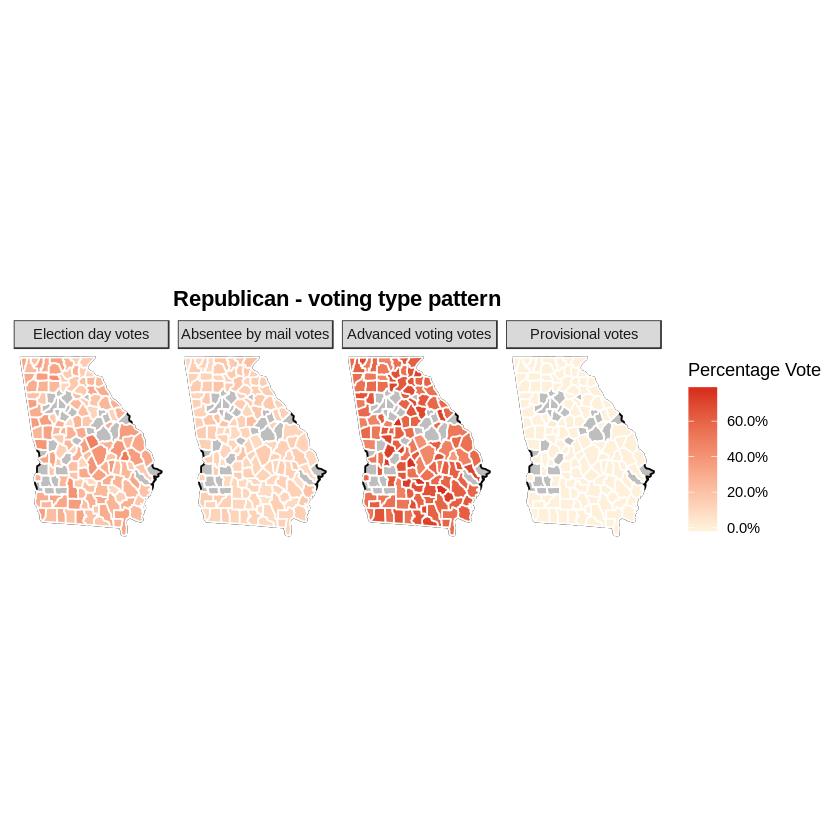

In [60]:
rep_vote_pattern = ga_base +
  geom_polygon(data = rawdata2020_melt_b %>% filter(party=='republican',winner=='republican'), aes(fill = value), color = "white") +
  theme_bw() +
  remove_the_axis +
  ggtitle("Republican - voting type pattern")  + theme(plot.title = element_text(face = "bold")) + theme(plot.title = element_text(hjust = 0.5)) +
  scale_fill_gradient(low = "#fef0d9", high = "#d7301f",name ='Percentage Vote',labels = percent,breaks=c(0,0.2,.4,.6,.8,1)) +
facet_grid(~variable)

rep_vote_pattern

In [61]:
# rawdata2020_melt%>%filter(county=='appling',variable=='election.day.votes')%>%group_by(county) %>% summarize(election.day.votes=sum(value))

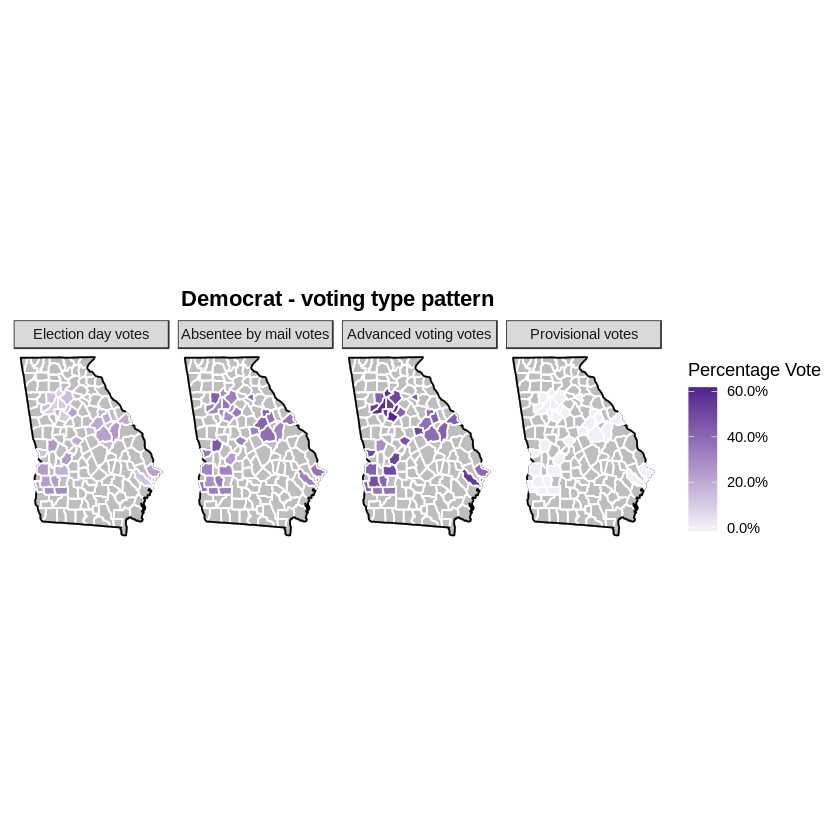

In [62]:
dem_vote_pattern = ga_base +
  geom_polygon(data = rawdata2020_melt_b %>% filter(party=='democrat',winner=='democrat'), 
               aes(fill = value), color = "white") +
  theme_bw() +
  remove_the_axis +
  ggtitle("Democrat - voting type pattern") + theme(plot.title = element_text(face = "bold")) + theme(
      plot.title = element_text(hjust = 0.5))+
scale_fill_gradient(low = "#f2f0f7", high = "#54278f",name ='Percentage Vote',labels = percent,breaks=c(0,0.2,.4,.6,.8,1)) +
# scale_fill_gradient(low = "#cbc9e2", high = "#54278f",name ='Percentage Vote',labels = percent,breaks=c(0,0.2,.4,.6)) +
facet_grid(~variable)

dem_vote_pattern

In [63]:
bar = rawdata2020_melt %>% group_by(winner,party,county) %>% summarize (county.election.day.votes = mean(county.election.day.votes),
                                                                 county.absentee.by.mail.votes = mean (county.absentee.by.mail.votes),
                                                                 county.advanced.voting.votes = mean (county.advanced.voting.votes),
                                                                 county.provisional.votes = mean(county.provisional.votes)) %>%
group_by(party) %>% summarize (county.election.day.votes = mean(county.election.day.votes),
                                                                 county.absentee.by.mail.votes = mean (county.absentee.by.mail.votes),
                                                                 county.advanced.voting.votes = mean (county.advanced.voting.votes),
                                                                 county.provisional.votes = mean(county.provisional.votes)) 

bar_melt = reshape2::melt(bar,id=c(1))
levels(bar_melt$variable) = c('Election day votes','Absentee by mail votes','Advanced voting votes','Provisional votes')


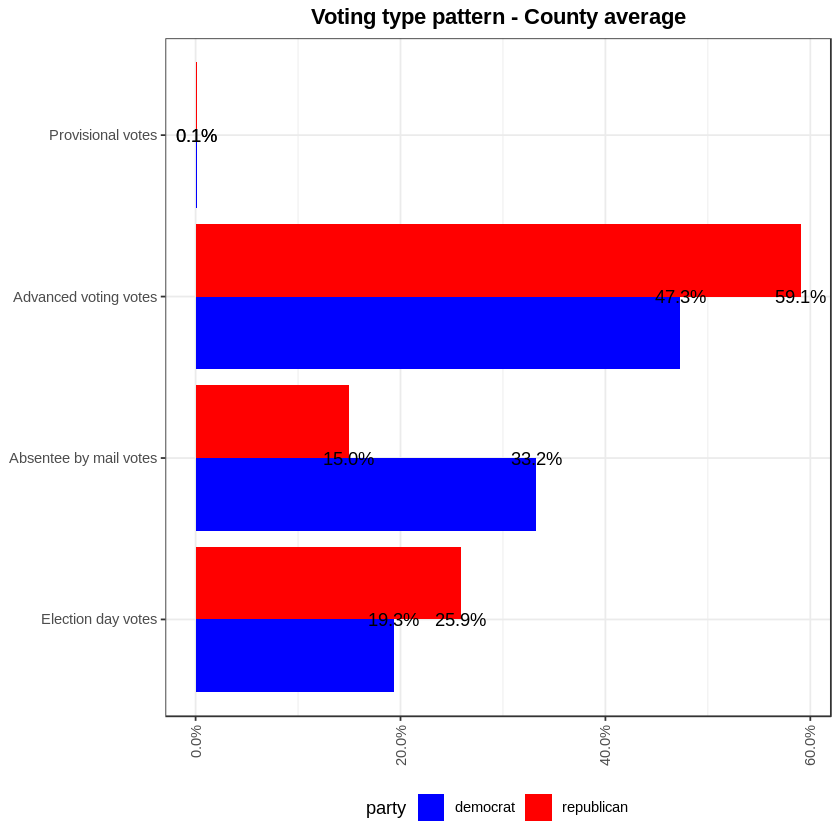

In [64]:

ggplot(data=bar_melt, aes(x=variable,y=value,fill=party)) + 
 geom_bar(stat='identity',position=position_dodge()) +theme_bw()+
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+scale_fill_manual(values= c('blue','red')) +
scale_y_continuous(labels = scales::percent) + ggtitle("Voting type pattern - County average") + theme(plot.title = element_text(face = "bold")) + theme(
      plot.title = element_text(hjust = 0.5)) +
theme(axis.title.x=element_blank(),
    axis.title.y=element_blank(),legend.position="bottom" ) +geom_text(aes(x= variable,y = value, label = scales::percent(value)))+coord_flip()